## Transition indicators (TIs)

The present notebook aims to provide exemplary computation of TIs. Therefore, two systems are studied:
1. a linear system (therefore incapable of undergoing critical transitions) to test the presence of false positives.
2. a nonlinear system representing a 1D double-well that undergoes a critical transition to test true positives.

First we load the packages and self-written functions:

In [17]:
using DrWatson
@quickactivate "StatisticalEWS"

using BenchmarkTools, DifferentialEquations

include(srcdir("utils.jl"))
include(srcdir("signal_processing.jl"))
include(srcdir("transition_indicators.jl"))
include(srcdir("significance_test.jl"))

check_std_endpoint (generic function with 1 method)

#### Model definition

We let both aforementioned models be forced by a user-defined function. In the present case, this is a simple linear drift such that the double-well model is driven out of its original equilibrium (i.e. experiences a transition).

In [2]:
# Deterministic part of linear system.
function f_linear(dx, x, p, t)
    dx[1] = p["λ"] * (x[1] + 1) + forcing(p, t)
end

# Deterministic part of double-well system.
function f_doublewell(dx, x, p, t)
    dx[1] = -x[1]^3 + x[1] + forcing(p, t)
end

# Stochastic part of system for noise.
function g_whitenoise(dx, x, p, t)
    dx[1] = p["σ"]
end

function forcing(p, t)
    return p["α"] * t
end

forcing (generic function with 1 method)

#### Perform simulation

In [3]:
# Define time step, vector and span. IC set for equilibrium of both systems.
dt = 1f-2
t = collect(0f0:dt:10f0)
tspan = extrema(t)
x0 = [-1f0]

pmodel = Dict("σ" => .1f0, "λ" => -1f0, "α" => .1f0)
models = [f_linear, f_doublewell]
labels = ["linear", "doublewell"]
nmodels = length(models)
X = zeros(Float32, nmodels, length(t))

for (f, lbl, i) in zip(models, labels, 1:nmodels)
    prob = SDEProblem(f, g_whitenoise, x0, tspan, pmodel)
    sol = solve(prob, EM(), dt=dt)
    X[i, :] = vcat(sol.u...)
end

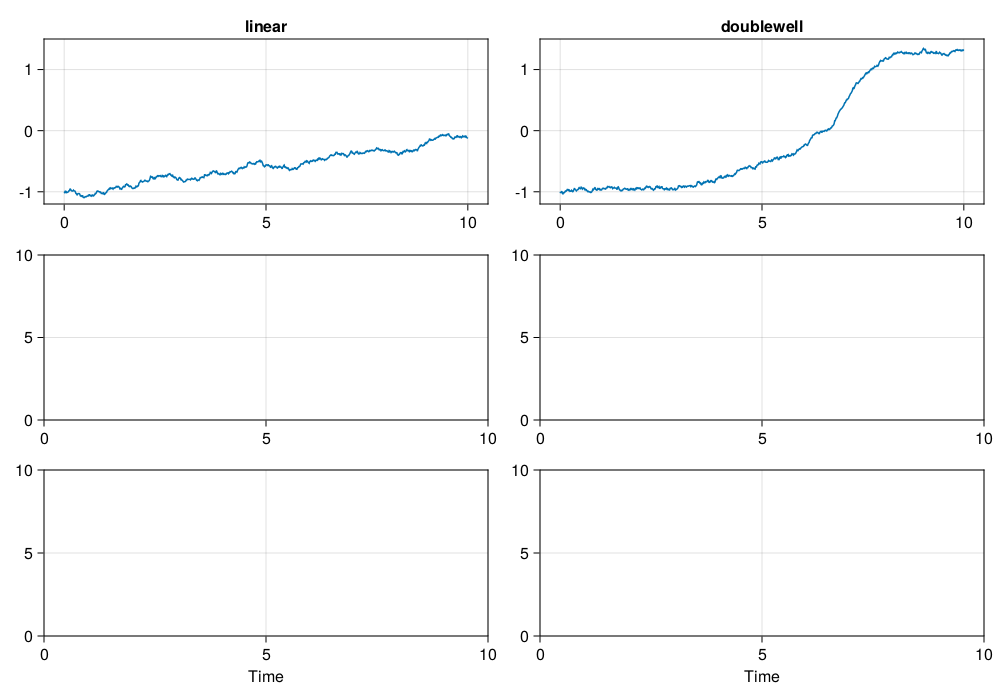

In [4]:
nrows, ncols = 3, nmodels
fig = Figure( resolution = (1000, 700) )
axs = [[Axis(
    fig[i,j],
    title = ( i==1 ? labels[j] : " "),
    xlabel = ( i==nrows ? "Time" : " "),
    ) for j in 1:ncols] for i in 1:nrows]

[lines!(axs[1][i], t, X[i, :], label = "data") for i in 1:ncols]
[ylims!(axs[1][i], (-1.2, 1.5)) for i in 1:ncols]
fig

#### Detrend time series

In order to obtain the noise response, the time series is detrended. For this, several algorithms can be used:
- Rolling average
- Gaussian kernel
- Butterworth filter
- More to come...

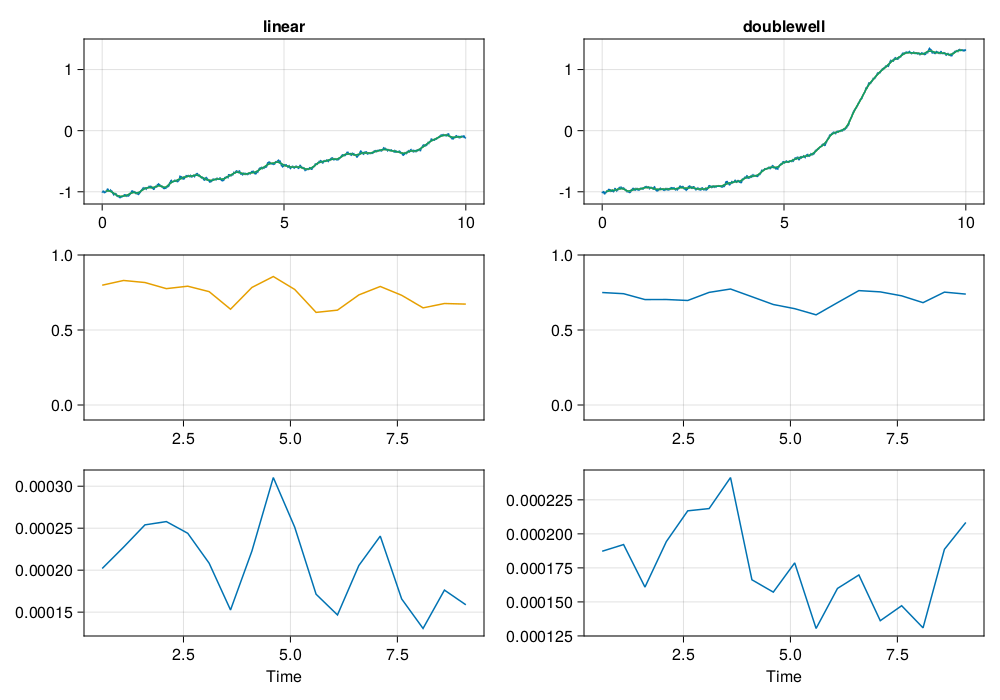

In [21]:
T_smooth_wndw = 1f-1        # half-width for smoothing window.
T_smooth_strd = dt          # stride of smoothing computation.
p_window_smooth = get_windowing_params([dt, T_smooth_wndw, T_smooth_strd])

window = centered_wndw
gettrend = gettrend_rollmean

Xtrend = mapslices( x_ -> gettrend(x_, p_window_smooth), X; dims=2 )
ttrend = trim_wndw( t, pwndw. )
[lines!(axs[1][i], ttrend, Xtrend[i, :], label = "trend") for i in 1:nmodels]
fig

#### Compute exemplary TIs

The most commonly used TIs are the variance and the coefficient of an AR1 regression of the residual. They are both expected to increase whenever a critical transition is near. Let's compute them and see what happens!

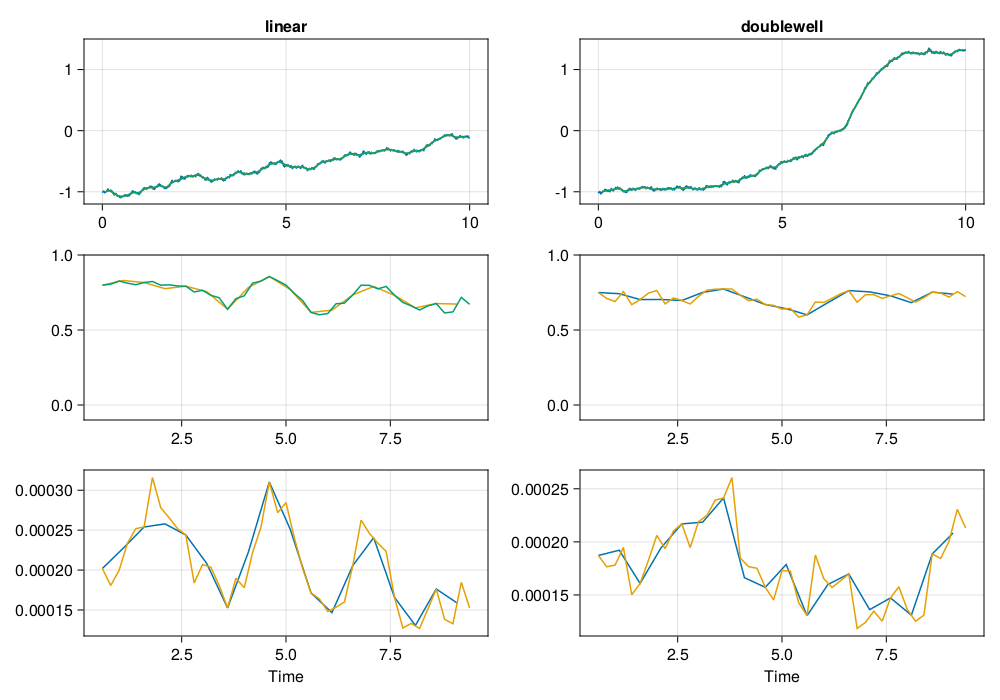

In [22]:
T_indctr_wndw = 5f-1          # half-width for computation of indicator.
T_indctr_strd = 2f-1          # stride for computation of indicator.

Xres_cpu = trim_wndw(X, pwndw.) - Xtrend
var_cpu = slide_estimator( Xres_cpu, pwndw, cpvar, window, "indicator" )
ar1_cpu = slide_estimator( Xres_cpu, pwndw, ar1_whitenoise, window, "indicator" )
tindctr = trim_wndw(ttrend, pwndw.N_indctr_wndw, pwndw.N_indctr_strd, window)

[lines!(axs[2][j], tindctr, ar1_cpu[j, :], label = "ar1_cpu") for j in 1:ncols]
[lines!(axs[3][j], tindctr, var_cpu[j, :], label = "var_cpu") for j in 1:ncols]
[ylims!(axs[2][i], (-.1, 1)) for i in 1:ncols]
fig

## Statistical significance

As we can observe in the previous plot, the critical transition of the double-well system in fact leads to an increase of the TIs!.. But such an increase also happens on the linear system, where no critical transition is possible. Meh. This means that along with true positives, we also want to get false ones.

Our way out of producing false positives is to test statistical significance by:
- Generating Fourier surrogates of the time series.
- Compute the transition indicator on each of these surrogates.
- Compute a metric that renders an increase of this indicator.
- Compare the increase metric of our actual time series with the ones computed on the surrogates.

The last step allows us to better investigate whether the increase of the TI is an artefact or not.

#### Fourier surrogates

Getting more data can be expensive (e.g. run a large model) or even barely possible (e.g. gather real-world data of the Earth system). However, (Fourier) surrogates of a given time series can be generated by:
- computing the Fourier transform of the time series.
- apply a random phase shift to each frequency.
- compute the inverse transform of the shifted spectrum.

To understand this with a simple example, one can imagine to have a time series x(t) given by:

$$ x(t) = \sin(t) + \sin(2 \pi \, t + \pi) $$

A Fourier surrogate of this could be:

$$ x_s(t) = \sin(t + 0.4 \, \pi) + \sin(2 \pi \, t + 2.7 \, \pi) $$

To generate such surrogates, TransitionIndicators.jl provides a ready-to-use function:

In [7]:
ns = 10000
Scpu = generate_stacked_fourier_surrogates(Xres_cpu, ns)

UndefVarError: UndefVarError: Xres_cpu not defined

On our present case, the number of states is quite low (nx = 2) and the computation time of the surrogate generation is acceptable. However, if TIs are to be computed for 2D fields, the resulting number of states scales exponentially and so does the run-time of the CPU routine for surrogate generation. To perform better, we can use a GPU version of the previous function by simply passing a CUDA array instead of a common julian matrix.

In [8]:
Xres_gpu = CuArray( Xres_cpu )
Sgpu = generate_stacked_fourier_surrogates(Xres_gpu, ns)

UndefVarError: UndefVarError: Xres_cpu not defined

Let's benchmark both to see if we got any improvement:

In [9]:
@benchmark generate_stacked_fourier_surrogates($Xres_cpu, $ns)

UndefVarError: UndefVarError: Xres_cpu not defined

In [10]:
@benchmark generate_stacked_fourier_surrogates($Xres_gpu, $ns)

UndefVarError: UndefVarError: Xres_gpu not defined

Looks like a factor 100 of speed up!!!

#### Compute surrogate TIs

We can now perform the computation of the TIs by simply using:

In [ ]:
# STI = slide_estimator( Scpu.S, pwndw.N_indctr_wndw, ar1_whitenoise )
STI = slide_estimator( Scpu.S, pwndw, ar1_whitenoise, window )

Ouch. 10 000 surrogates is quite substantial and implies large dimension of the 3D surrogate array which in turn (surprise, surprise) leads to large computational cost. Moreover, the present case handles only two time series but applications sometimes present thousands of them (e.g. resulting from a 100 x 100 2D field). We might need something that scales better!

Instead of performing loops, we can transform the whole computation into a sparse array multiplication, which saves a lot of time:

In [ ]:
STIsp = ar1_whitenoise( Scpu.S, pwndw )[:, pwndw.N_indctr_wndw+1:end-pwndw.N_indctr_wndw+1]

#### GPU accelerated TI computation

Some operations can be efficiently parallelised on GPUs. For high dimensionality, this can provide a significant speed-up, as e.g.:

In [ ]:
ntest = 1000
Acpu = rand(ntest, ntest)
@benchmark $Acpu * $Acpu

In [ ]:
Agpu = CUDA.rand(ntest, ntest)
@benchmark $Agpu * $Agpu

For some TIs, a GPU-accelerated version of the computation has been implemented. This is the case for:
- Variance
- Skewness
- Kurtosis
- AR1 coefficient with white noise assumption

In [ ]:
Sgpu = CuArray(Scpu.S)

In [ ]:
M = gpuMask(Sgpu, pwndw)

In [ ]:
STIgpu = ar1_whitenoise(Sgpu, M)

In [ ]:
STIgpucpu = Array(STIgpu)[:, pwndw.N_indctr_wndw+1:end-pwndw.N_indctr_wndw+1]

In [ ]:
i = 2000
fig_test = Figure()
ax_test = Axis(fig_test[1,1])
lines!(ax_test, STI[i, :])
lines!(ax_test, STIsp[i, :])
lines!(ax_test, STIgpucpu[i, :], linestyle = :dash)
xlims!(ax_test, (400, 600))
fig_test

In [ ]:
sum( abs.(STIgpucpu - STI) .> 1f-1 ) # / length(STI)

Let's benchmark our solutions, going from worst to best!

In [ ]:
@benchmark slide_estimator( $Scpu.S, $pwndw.N_indctr_wndw, ar1_whitenoise )

In [ ]:
@benchmark ar1_whitenoise( $Scpu.S, $pwndw )

In [ ]:
@benchmark ar1_whitenoise( $Sgpu, $M )

On the machine where the code was tested, the CPU function needs about 0.7 seconds to run, whereas the GPU only needs about 0.02 seconds. This leads to a roughly estimated speed-up of factor 35 - take that computational complexity! The absolute values are of course machine-specific and you might observe different ones.

In [ ]:
B = CuArray( reshape(1f0:980f0*2f0, 2, 980) )
cumean(B, M, pwndw)

## Trend measure of indicators



In [ ]:
T_signif_wndw = 5f-1          # half-width for computation of indicator significance.
T_signif_strd = 2f-1          # stride for computation of indicator significance.